Initial potential energy  -0.17273732250418838
Initial kinetic energy  12.000000000000005
elapsed time: 0.09 seconds, performance 531.66 steps/second
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:254: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:254: RuntimeWarning: invalid value encountered in subtract
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:255: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater_equal
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in greater_equal
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


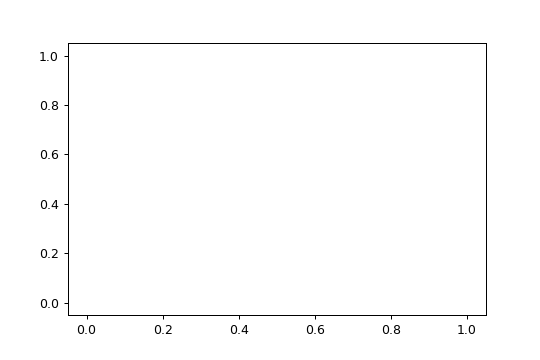

In [4]:

# this is Prof. Statt's code

import numpy as np 
import time 
import math
import scipy.spatial
from scipy.spatial import cKDTree as KDTree
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

def kinetic_energy(m, v):
    """
    args:
        m (float): mass of particles
        v (array): velocities of particles,
        assumed to be a 2D array of shape (N, 3)
    returns:
        float: total kinetic energy
    """
    total_vsq = np.einsum('ij,ij', v, v)
    return 0.5*m*total_vsq

def potential_energy(pos, rc, L):
    """
    args:
        dist (array): distance table with shape (N, N)
            i.e. dist[i,j] is the distance
            between particle i and particle j
            in the minimum image convention
            note that the diagonal of dist can be zero
        rc (float): cutoff distance for interaction
            i.e. if dist[i,j] > rc, the pair potential between
            i and j will be 0
        L: box length 
    returns:
        float: total potential energy
    """
    # dist = scipy.spatial.distance.pdist(pos) 
    # dist = np.where(dist > 0.5*L, dist-L, np.where(dist < -0.5*L, dist+L , dist))

    table = pos[:,np.newaxis,:] - pos[np.newaxis,:,:]
    dist_vec = minimum_image(table,L) 
    dist_vec[np.diag_indices(len(dist_vec))] = np.inf
    r = np.linalg.norm(dist_vec,axis=-1)
    
    v = 4*((1/r)**12-(1/r)**6)
    vc = 4*((1/rc)**12-(1/rc)**6)
    v[r < rc] -= vc #shift
    v[r >= rc] = 0 #cut
    return 0.5*np.sum(v)

def minimum_image(r, L):
    """
    args:
        r : array of any shape
        L : box size
    returns:
        array of the same shape as r,
        the minimum image of r
    """
    return r - L*np.round(r / L)

def initial_positions(N,radius,L):
    """ 
    Simple helper function to generate fcc positions 
    
    args: 
        N (int): number of particles 
        L (float): side length of cubic box
        radius (float): distance on lattice 
    returns:
        array of shape (N,3) with particle positions on fcc lattice 
     """
    a = radius*np.sqrt(2)*2
    S = list(np.arange(-L/2.,L/2.-a, a))
   
    FCC = list(itertools.product(S,S,S))
    FCC = np.vstack((FCC,
            FCC+a/2.*np.array([1,1,0]),
            FCC+a/2.*np.array([1,0,1]),
            FCC+a/2.*np.array([0,1,1])
            ))
    
    q = np.random.choice(len(FCC),N,replace=False)
    return FCC[q]

def initial_velocities(N, m, T):
    """
    initialize velocities at a desired temperature
    required for: initialization

    args:
        N (int): number of particles
        m (float): mass of particles
        T (float): desired temperature
    returns:
        array: initial velocities, with shape (N, 3)
    """
    velocities = np.random.rand(N,3)-0.5
    #zero the total net velocity
    velocities -= np.average(velocities,axis=0)
    # correct temperature
    current_temp = 2*kinetic_energy(m,velocities)/(3*N)
    velocities *= np.sqrt(T / current_temp)
    return velocities

def velocity_verlet(force_func,pos,vel,mass,dt,rc,L):
    """
    advance system according to velocity verlet

    args:
        force_func: a function that calculates all forces between all particles 
        pos (array): coordinates of particles
        vel (array): velocities of particles
        mass (float): mass of particles
        dt (float): timestep by which to advance

        rc (float): cutoff
        L (float): length of cubic box
    returns:
        array, array: new positions, new velocities
    """ 
    
    accel = force_func(pos,rc,L) / mass
    #move
    vel_half = vel + 0.5*dt*accel
    pos_new = pos + dt*vel_half
    pos_new = minimum_image(pos_new, L)
    
    #repeat force calculation for new pos
    accel = force_func(pos_new,rc,L) / mass
    #finish move
    vel_new = vel_half + 0.5*dt*accel
    
    return pos_new, vel_new

# above is to visually present the initial condition

def force_smarter(pos,rc,L):
    """
    calculate forces for all particles in system 
    args:
        pos (array): all positions, shape (N,3)
        rc (float): cutoff distance for interaction
        i.e. if dist[i,j] > rc, particle i will feel no force
        from particle j
        L (float): box size 
    returns:
        array: forces f on all particles, with shape (N, 3)
        i.e. f[3,0] gives the force on particle i
        in the x direction
    """
    table = pos[:,np.newaxis,:] - pos[np.newaxis,:,:]
    dist_vec = minimum_image(table,L) 
    dist_vec[np.diag_indices(len(dist_vec))] = np.inf
    r_len = np.linalg.norm(dist_vec,axis=-1)
    one_over_r_squared = 1./pow(r_len,2)
    one_over_r_six = pow(one_over_r_squared,3)
    magnitude = 24.*one_over_r_six*one_over_r_squared*(2.*one_over_r_six - 1)
    magnitude[r_len >= rc] = 0
    val = magnitude[:,:,np.newaxis]*dist_vec
    val = np.nansum(val, axis=1)
    
    return val 

def displacement_table(coordinates, L):
    """
    required for: force(), advance()
    args:
        coordinates (array): coordinates of particles,
        assumed to have shape (N, 3)
        e.g. coordinates[3,0] should give the x component
        of particle 3
        L (float): side length of cubic box,
        must be known in order to compute minimum image
    returns:
        array: table of displacements r
        such that r[i,j] is the minimum image of
        coordinates[i] - coordinates[j]
    """
    #coordinates=np.array(coordinates)
    coordinates=my_pos_in_box(coordinates,L)
    #print(coordinates)
    #coordinates=coordinates.tolist()
    N=len(coordinates)
    r=np.zeros((N,N,3))
    
    for i in range(N):
        for j in range(N):
            r[i][j][0]=coordinates[i][0]-coordinates[j][0]
            r[i][j][1]=coordinates[i][1]-coordinates[j][1]
            r[i][j][2]=coordinates[i][2]-coordinates[j][2]
        r[i]=minimum_image(r[i],L)
    #print(r)
    return r

def eventmap(pos, vel, sigma):
    """
    this function calculate the time of each event happens
    input: pos: Nx3, position of all particles
    vel: Nx3, velocities of all particles
    return: t: NxN, event map
    
    """
    N=len(pos) # number of particles
    r=np.zeros((N,N,3)) # r is the displacement of all particles
    v=np.zeros((N,N,3)) # v is relative velocity of all particles
    t=np.zeros((N,N))
    # r[i,j]=ri-rj, a vector
    for i in range(N):
        for j in range(N):
            r[i][j]=np.subtract(pos[i],pos[j])
            v[i][j]=np.subtract(vel[i],vel[j])
            vij=np.linalg.norm(v[i][j]) # norm of vij
            rij=np.linalg.norm(r[i][j]) # norm of rij
            delta=(2*np.dot(r[i][j],v[i][j])**2-4*vij**2*(rij**2-sigma**2))
            if delta>=0:
                t[i][j]=(-2*np.dot(r[i][j],v[i][j])+np.sqrt(delta))/(2*vij**2)
            else:
                t[i][j]=5000; # assign a large number
    return t

def pressure(pos, force, V, T):
    N = len(pos)
    P = N*T/V
    for i in range(N):
        P = P+np.dot(pos[i],force[i])/(3*V)
    return P  

def force_double_sum(pos,rc,L):
    """
    calculate forces for all particles in system 
    args:
        pos (array): all positions, shape (N,3)
        rc (float): cutoff distance for interaction
        i.e. if dist[i,j] > rc, particle i will feel no force
        from particle j
        L (float): box size 
    returns:
        array: forces f on all particles, with shape (N, 3)
        i.e. f[3,0] gives the force on particle i
        in the x direction
    """
    N,dim = pos.shape 
    force_all = np.zeros(shape=(N,dim))
    for i in range(N):
        for j in range(N):
            r = minimum_image(pos[i]-pos[j], L) # distance vector 
            r_len = np.linalg.norm(r) # distance 
            force_ij = np.zeros(shape=(dim))
            if r_len <= rc:
                magnitude = (48./r**14- 24./r**8)
                force_ij = magnitude*(r/r_len)
    
            force_all[i] += force_ij
            
            
    return force_all 


def advance(colli, pos, vel, sigma):
    """
    advance colli number of collisions
    return: pos and vel
    """
    for i in range(colli):
        N=len(pos)
        tmap=eventmap(pos, vel, sigma)

        minind = np.nanargmin(tmap)
        mint = np.nanmin(tmap)

        i = minind // N # minind=i*N+j  t[i][j] is the smallest
        j = minind % N
        if mint==5000 or mint<0:
            mint=0
            i=0
            j=0
            continue

        pos = pos+vel*mint
        rij_vec=pos[i]-pos[j]
        rij = np.linalg.norm(rij_vec) # norm of rij_vec
        vij_vec=vel[i]-vel[j]
        vel[i]=vel[i] - (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
        vel[j]=vel[j] + (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    

    return pos, vel

N = 8
Lbox = 9
L = Lbox
T = 1.0
mass = 48.0
dt = 0.005
rc = 3.0
sigma=1 # radius of the particles
V = Lbox**3

'''pos = initial_positions(N,0.5,Lbox)
vel = initial_velocities(N,mass,T)
colli=3

tmap=eventmap(pos, vel, sigma)
print(tmap)
[pos1,vel1]=advance(colli, pos, vel, sigma)
print(pos1)   
print(pos)
'''

pos = initial_positions(N,0.5,Lbox)
vel = initial_velocities(N,mass,T)

p = potential_energy(pos,rc,Lbox)
k = kinetic_energy(mass,vel)

print("Initial potential energy ",p)
print("Initial kinetic energy ",k)

PE = []
KE = []
start = time.time()
Nsteps=50
P = []
for i in range(Nsteps):
    pos,vel = velocity_verlet(force_double_sum,pos,vel,mass,dt,rc,Lbox)
    PE.append(potential_energy(pos,rc,Lbox))
    KE.append(kinetic_energy(mass,vel))
    force = force_smarter(pos,rc,L)
    pres = pressure(pos, force, V, T)
    P.append(pres)
end = time.time()
total_time =(end - start)
print('elapsed time: %3.2f seconds, performance %3.2f steps/second' % (total_time,Nsteps/total_time))
print(PE+KE)
plt.plot(PE+KE)


In [84]:


# this is after realizing non wall interaction part of the code

import numpy as np 
import time 
import math
import scipy.spatial
from scipy.spatial import cKDTree as KDTree
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

def kinetic_energy(m, v):
    """
    args:
        m (float): mass of particles
        v (array): velocities of particles,
        assumed to be a 2D array of shape (N, 3)
    returns:
        float: total kinetic energy
    """
    total_vsq = np.einsum('ij,ij', v, v)
    return 0.5*m*total_vsq

def initial_positions(N,radius,L):
    """ 
    Simple helper function to generate fcc positions 
    
    args: 
        N (int): number of particles 
        L (float): side length of cubic box
        radius (float): distance on lattice 
    returns:
        array of shape (N,3) with particle positions on fcc lattice 
     """
    a = radius*np.sqrt(2)*2
    S = list(np.arange(-L/2.,L/2.-a, a))
   
    FCC = list(itertools.product(S,S,S))
    FCC = np.vstack((FCC,
            FCC+a/2.*np.array([1,1,0]),
            FCC+a/2.*np.array([1,0,1]),
            FCC+a/2.*np.array([0,1,1])
            ))
    
    q = np.random.choice(len(FCC),N,replace=False)
    return FCC[q]

def initial_velocities(N, m, T):
    """
    initialize velocities at a desired temperature
    required for: initialization

    args:
        N (int): number of particles
        m (float): mass of particles
        T (float): desired temperature
    returns:
        array: initial velocities, with shape (N, 3)
    """
    velocities = np.random.rand(N,3)-0.5
    #zero the total net velocity
    velocities -= np.average(velocities,axis=0)
    # correct temperature
    current_temp = 2*kinetic_energy(m,velocities)/(3*N)
    velocities *= np.sqrt(T / current_temp)
    return velocities

def eventmap(pos, vel, sigma, L):
    """
    this function calculate the time of each event happens
    input: pos: Nx3, position of all particles
    vel: Nx3, velocities of all particles
    return: tpart: NxN, event map for particle collision
    tw: Nx6, event map for particle wall collision
    """
    N=len(pos) # number of particles
    r=np.zeros((N,N,3)) # r is the displacement of all particles
    v=np.zeros((N,N,3)) # v is relative velocity of all particles
    tpart=np.zeros((N,N)) # particle collision timetable
    # r[i,j]=ri-rj, a vector
    for i in range(N):
        for j in range(N):
            r[i][j]=np.subtract(pos[i],pos[j])
            v[i][j]=np.subtract(vel[i],vel[j])
            vij=np.linalg.norm(v[i][j]) # norm of vij
            rij=np.linalg.norm(r[i][j]) # norm of rij
            delta=(2*np.dot(r[i][j],v[i][j])**2-4*vij**2*(rij**2-sigma**2))
            if delta>=0:
                tpart[i][j]=(-2*np.dot(r[i][j],v[i][j])+np.sqrt(delta))/(2*vij**2)
            else:
                tpart[i][j]=5000; # assign a large number
            
    # below is the timetable for walls.
    tw=np.zeros((N,6)) # wall collision timetable
    for i in range(N):
        length_left = np.subtract(pos[i],-L/2)
        tback = np.divide(length_left,-vel[i])
        length_right = np.subtract(L/2,pos[i])
        tforward = np.divide(length_right,vel[i])
        a = [tback,tforward]
        tw[i]=np.reshape(a,[1,6])
    
    return tpart, tw

def advance(pos, vel, sigma, L, m):
    """
    advance colli number of collisions
    return: pos and vel
    """
    N=len(pos)
    [tpart, twall]=eventmap(pos, vel, sigma, L)

    minind = np.nanargmin(tpart)
    mint = np.nanmin(tpart)
    
    i = minind // N # minind=i*N+j  t[i][j] is the smallest
    j = minind % N
    if mint<0:
        mint=5000
        i=0
        j=0
        
    #print('mint_part is ',mint)
    mint_wall = np.min(twall[twall>0])
    #print('mint_wall is ',mint_wall)
    [iw, jw] = np.where(twall==mint_wall)
    

    if mint < mint_wall:
        pos = pos+vel*mint
        rij_vec=pos[i]-pos[j]
        rij = np.linalg.norm(rij_vec) # norm of rij_vec
        vij_vec=vel[i]-vel[j]
        vel[i]=vel[i] - (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
        vel[j]=vel[j] + (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
        t_pass=(mint)
    else: 
        pos = pos+vel*mint_wall
        b = jw % 3
        vel[iw,b] = -vel[iw,b]
        t_pass=(mint_wall)
        p = 2*np.absolute(vel[iw,b])*m/t_pass

    return pos, vel, t_pass, p

N = 8
Lbox = 9
T = 1.0
mass = 48.0
dt = 0.005
rc = 3.0
sigma=1 # radius of the particles

pos = initial_positions(N,0.5,Lbox)
vel = initial_velocities(N,mass,T)
colli=100

tmap=eventmap(pos, vel, sigma, Lbox)

timepassed=[0]
KE=[kinetic_energy(mass,vel)]
pressure=[]
for i in range(1,colli):
    [pos, vel, time, p]=advance(pos, vel, sigma, Lbox)
    
    KE.append(kinetic_energy(mass,vel))
    timepassed.append(time+timepassed[i-1])
print('pos after',pos1)   
print('KE',KE)
print('timepassed',timepassed)

1 5000.0
1


In [15]:
# this is to separate the advance function into several parts

import numpy as np 
import time 
import math
import scipy.spatial
from scipy.spatial import cKDTree as KDTree
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

def kinetic_energy(m, v):
    """
    args:
        m (float): mass of particles
        v (array): velocities of particles,
        assumed to be a 2D array of shape (N, 3)
    returns:
        float: total kinetic energy
    """
    total_vsq = np.einsum('ij,ij', v, v)
    return 0.5*m*total_vsq

def initial_positions(N,radius,L):
    """ 
    Simple helper function to generate fcc positions 
    
    args: 
        N (int): number of particles 
        L (float): side length of cubic box
        radius (float): distance on lattice 
    returns:
        array of shape (N,3) with particle positions on fcc lattice 
     """
    a = radius*np.sqrt(2)*2
    S = list(np.arange(-L/2.,L/2.-a, a))
   
    FCC = list(itertools.product(S,S,S))
    FCC = np.vstack((FCC,
            FCC+a/2.*np.array([1,1,0]),
            FCC+a/2.*np.array([1,0,1]),
            FCC+a/2.*np.array([0,1,1])
            ))
    
    q = np.random.choice(len(FCC),N,replace=False)
    return FCC[q]

def initial_velocities(N, m, T):
    """
    initialize velocities at a desired temperature
    required for: initialization

    args:
        N (int): number of particles
        m (float): mass of particles
        T (float): desired temperature
    returns:
        array: initial velocities, with shape (N, 3)
    """
    velocities = np.random.rand(N,3)-0.5
    #zero the total net velocity
    velocities -= np.average(velocities,axis=0)
    # correct temperature
    current_temp = 2*kinetic_energy(m,velocities)/(3*N)
    velocities *= np.sqrt(T / current_temp)
    return velocities

def eventmap(pos, vel, sigma, L):
    """
    this function calculate the time of each event happens
    input: pos: Nx3, position of all particles
    vel: Nx3, velocities of all particles
    return: tpart: NxN, event map for particle collision
    tw: Nx6, event map for particle wall collision
    """
    N=len(pos) # number of particles
    r=np.zeros((N,N,3)) # r is the displacement of all particles
    v=np.zeros((N,N,3)) # v is relative velocity of all particles
    tpart=np.zeros((N,N)) # particle collision timetable
    # r[i,j]=ri-rj, a vector
    for i in range(N):
        for j in range(N):
            r[i][j]=np.subtract(pos[i],pos[j])
            v[i][j]=np.subtract(vel[i],vel[j])
            vij=np.linalg.norm(v[i][j]) # norm of vij
            rij=np.linalg.norm(r[i][j]) # norm of rij
            delta=(2*np.dot(r[i][j],v[i][j])**2-4*vij**2*(rij**2-sigma**2))
            if delta>=0:
                tpart[i][j]=(-2*np.dot(r[i][j],v[i][j])+np.sqrt(delta))/(2*vij**2)
            else:
                tpart[i][j]=5000; # assign a large number
            
    # below is the timetable for walls.
    tw=np.zeros((N,6)) # wall collision timetable
    for i in range(N):
        length_left = np.subtract(pos[i],-L/2)
        tback = np.divide(length_left,-vel[i])
        length_right = np.subtract(L/2,pos[i])
        tforward = np.divide(length_right,vel[i])
        a = [tback,tforward]
        tw[i]=np.reshape(a,[1,6])
    
    return tpart, tw

def comparetime(pos, vel, L):
    """
    advance colli number of collisions
    return: pos and vel
    """
    N=len(pos)
    [tpart, twall]=eventmap(pos, vel, sigma, L)

    minind = np.nanargmin(tpart)
    mint = np.nanmin(tpart)
    
    i = minind // N # minind=i*N+j  t[i][j] is the smallest
    j = minind % N
    if mint<0:
        mint=5000
        i=0
        j=0
        
    #print('mint_part is ',mint)
    mint_wall = np.min(twall[twall>0])
    #print('mint_wall is ',mint_wall)
    [iw, jw] = np.where(twall==mint_wall)
    mint_smaller = mint<mint_wall
    smallerT=min(mint,mint_wall)
    return mint_smaller, i,j, iw,jw, smallerT

def proce_part(pos, vel, i, j, mint):
    pos = pos+vel*mint
    rij_vec=pos[i]-pos[j]
    rij = np.linalg.norm(rij_vec) # norm of rij_vec
    vij_vec=vel[i]-vel[j]
    vel[i]=vel[i] - (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    vel[j]=vel[j] + (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    #t_pass=(mint)
    return pos, vel

def proce_wall(pos, vel, iw, jw, m, mint_wall):
    pos = pos+vel*mint_wall
    b = jw % 3
    vel[iw,b] = -vel[iw,b]
    dmomentum = 2 * np.absolute(vel[iw,b]) * m
    return pos, vel, dmomentum

N = 16
Lbox = 9
L=Lbox
T = 1
mass = 48.0
dt = 0.005
rc = 3.0
sigma=1 # radius of the particles

# these are reduced units for Ar. 1=3.4A in length, 1=40/6.02*10^-23g= one Ar molecule mass
# 1=1.65*10^-21 in energy, temperature is 1=120K

pos = initial_positions(N,0.5,Lbox)
vel = initial_velocities(N,mass,T)
colli=2000

tmap=eventmap(pos, vel, sigma, Lbox)

timepassed=[0]
KE=[kinetic_energy(mass,vel)]
p=[]
timer=0
partbump=0
wallbump=0
for run in range(1,colli):
    [mint_smaller, i,j, iw,jw, smallerT] = comparetime(pos, vel, L)
    #print('smallerT',smallerT,'run',run)
    if mint_smaller:
        [pos, vel] = proce_part(pos, vel, i, j, smallerT)
        timer = timer+smallerT
        partbump=partbump+1
    else:
        [pos, vel, dmomentum] = proce_wall(pos, vel, iw, jw, mass, smallerT)
        timer = timer+smallerT
        pressure = dmomentum/timer
        timer = 0
        wallbump=wallbump+1
        
    p.append(pressure)
    KE.append(kinetic_energy(mass,vel))
    #print('timepassed run-1',timepassed[run-1])
    timepassed.append(smallerT+timepassed[run-1])
    if run==300:
        print('partbump',partbump,' timepassed',timepassed[run])
p.insert(0,0)
#print('pos after',pos)   
#print('p',p)
bumpf=np.divide(partbump,timepassed)
print('timepassed',timepassed)
print('partbump',partbump)
plt.plot(bumpf[200,:])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in double_scalars


partbump 87  timepassed 375.98375000915917
timepassed [0, 4.535038724763214, 5.430238209065389, 5.748312127353125, 7.313936183608537, 7.479790245521144, 8.283888770136997, 9.795155454668372, 11.667976261587887, 12.835580795295641, 14.355140142334994, 14.58242765873287, 16.993389982808235, 17.148905947995384, 17.776551923313697, 18.793680337110633, 19.716502993792965, 20.49350663866371, 21.80771574065122, 24.59734922028808, 24.824660237224762, 25.31101231486989, 26.34841031433427, 27.37794853743573, 28.007244532286958, 28.155141276894387, 29.120325317603356, 29.781787727035756, 36.50789008990125, 40.36273398503127, 41.65437369787866, 42.86632980988095, 43.348169181920184, 43.61209104724658, 43.86584982759521, 44.092006922679, 44.81703002881834, 44.89949744865443, 45.06679815201368, 45.429524198433725, 45.63188111672183, 46.07519199863051, 46.934806303601576, 47.32082168353142, 48.38193425491003, 48.498123435297735, 49.02133927192009, 49.6964420223425, 52.596183586675934, 52.747455925062

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in true_divide


IndexError: too many indices for array

0.20684160614279865


<IPython.core.display.Javascript object>


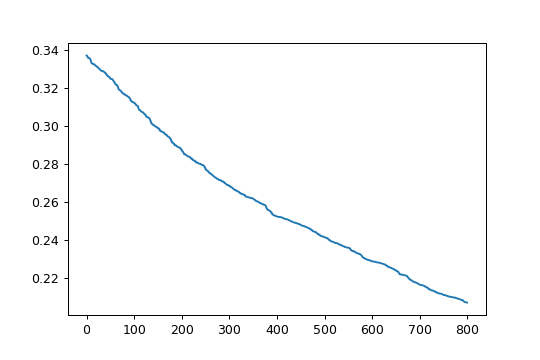

In [22]:
print(bumpf[-1])
plt.plot(bumpf[1200:2000])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars


theoretical P 0.016


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:260: RuntimeWarning: invalid value encountered in true_divide


wallbump 3271


<IPython.core.display.Javascript object>


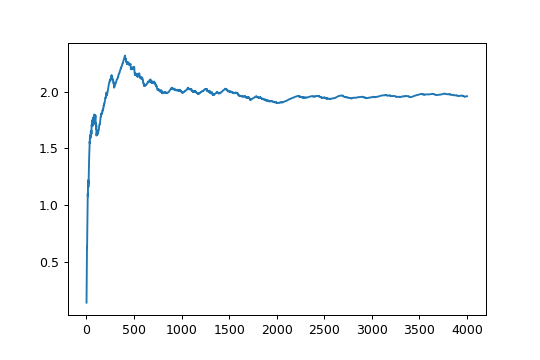

<IPython.core.display.Javascript object>


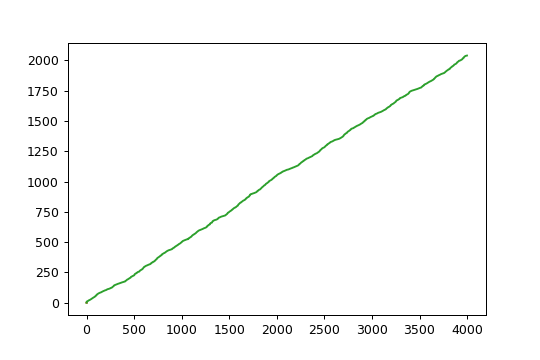

In [1]:
# this is to use PBC to calculate pressure
# actually, no PBC were used. 
# in this version of code. pressure and speed distribution have been fixed

import numpy as np 
import time 
import math
import scipy.spatial
from scipy.spatial import cKDTree as KDTree
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

def kinetic_energy(m, v):
    """
    args:
        m (float): mass of particles
        v (array): velocities of particles,
        assumed to be a 2D array of shape (N, 3)
    returns:
        float: total kinetic energy
    """
    total_vsq = np.einsum('ij,ij', v, v)
    return 0.5*m*total_vsq

def initial_positions(N,radius,L):
    """ 
    Simple helper function to generate fcc positions 
    
    args: 
        N (int): number of particles 
        L (float): side length of cubic box
        radius (float): distance on lattice 
    returns:
        array of shape (N,3) with particle positions on fcc lattice 
     """
    a = radius*np.sqrt(2)*2
    S = list(np.arange(-L/2.,L/2.-a, a))
   
    FCC = list(itertools.product(S,S,S))
    FCC = np.vstack((FCC,
            FCC+a/2.*np.array([1,1,0]),
            FCC+a/2.*np.array([1,0,1]),
            FCC+a/2.*np.array([0,1,1])
            ))
    
    q = np.random.choice(len(FCC),N,replace=False)
    return FCC[q]

def cubic_lattice(tiling, L):
    """
    required for: initialization
    args:
        tiling (int): determines number of coordinates,
        by tiling^3
        L (float): side length of simulation box
    returns:
        array of shape (tiling**3, 3): coordinates on a cubic lattice,
        all between -0.5L and 0.5L
    """
    a=tiling
    ini_pos=np.zeros((a**3,3))
    for i in range(a):
        for j in range(a):
            for k in range(a):
                index=i*a**2+j*a+k
                ini_pos[index][0]=-L/2+L/a*k+L/(2*a)
                ini_pos[index][1]=-L/2+L/a*j+L/(2*a)
                ini_pos[index][2]=-L/2+L/a*i+L/(2*a)
    return ini_pos

def initial_velocities(N, m, T):
    """
    initialize velocities at a desired temperature
    required for: initialization

    args:
        N (int): number of particles
        m (float): mass of particles
        T (float): desired temperature
    returns:
        array: initial velocities, with shape (N, 3)
    """
    velocities = np.random.rand(N,3)-0.5
    #zero the total net velocity
    velocities -= np.average(velocities,axis=0)
    # correct temperature
    current_temp = 2*kinetic_energy(m,velocities)/(3*N)
    velocities *= np.sqrt(T / current_temp)
    return velocities

def eventmap(pos, vel, sigma, L):
    """
    this function calculate the time of each event happens
    input: pos: Nx3, position of all particles
    vel: Nx3, velocities of all particles
    return: tpart: NxN, event map for particle collision
    tw: Nx6, event map for particle wall collision
    """
    N=len(pos) # number of particles
    r=np.zeros((N,N,3)) # r is the displacement of all particles
    v=np.zeros((N,N,3)) # v is relative velocity of all particles
    tpart=np.zeros((N,N)) # particle collision timetable
    # r[i,j]=ri-rj, a vector
    for i in range(N):
        for j in range(N):
            r[i][j]=np.subtract(pos[i],pos[j])
            v[i][j]=np.subtract(vel[i],vel[j])
            vij=np.linalg.norm(v[i][j]) # norm of vij
            rij=np.linalg.norm(r[i][j]) # norm of rij
            delta=(2*np.dot(r[i][j],v[i][j])**2-4*vij**2*(rij**2-sigma**2)) 
            
            # if delta for the quadratic equation is >0, then the two particles will bump.
            if delta>=0: 
                tpart[i][j]=(-2*np.dot(r[i][j],v[i][j])+np.sqrt(delta))/(2*vij**2)
            else:
                tpart[i][j]=5000; # assign a large number
            
    # below is the timetable for walls.
    tw=np.zeros((N,6)) # wall collision timetable
    # this table calculate the time they collide supposing they will bump.
    for i in range(N):
        length_left = np.subtract(pos[i],-L/2)
        tback = np.divide(length_left,-vel[i])
        length_right = np.subtract(L/2,pos[i])
        tforward = np.divide(length_right,vel[i])
        a = [tback,tforward]
        tw[i]=np.reshape(a,[1,6])
    
    return tpart, tw

def comparetime(pos, vel, L):
    """
    this function will judge the min of tpart is smaller or min of twall
    return: mint_smaller is a boolean value. if True, then min of tpart is smaller
    i,j is the coordinates of min of tpart
    iw, jw is the coordinates of min of twall
    smallerT is the smaller T value itself
    """
    N=len(pos)
    [tpart, twall]=eventmap(pos, vel, sigma, L)

    minind_part = np.nanargmin(tpart) # this is the index of munimal value
    mint_part = np.nanmin(tpart) # this is minimal value of tpart
    
    i = minind_part // N # minind=i*N+j  t[i][j] is the smallest
    j = minind_part % N
    if mint_part<0:
        mint_part=5000
        i=0
        j=0
        
    #print('mint_part is ',mint)
    mint_wall = np.min(twall[twall>0])
    #print('mint_wall is ',mint_wall)
    [iw, jw] = np.where(twall==mint_wall)
    
    mint_smaller = mint_part<mint_wall
    smallerT = min(mint_part,mint_wall)
    return mint_smaller, i,j, iw,jw, smallerT

def proce_part(pos, vel, i, j, mint):
    '''
    this function returns pos and vel after particle collision
    '''
    pos = pos+vel*mint
    rij_vec=pos[i]-pos[j]
    rij = np.linalg.norm(rij_vec) # norm of rij_vec
    vij_vec=vel[i]-vel[j]
    vel[i]=vel[i] - (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    vel[j]=vel[j] + (np.dot(rij_vec,vij_vec)/rij)*rij_vec/rij
    #t_pass=(mint)
    return pos, vel

def proce_wall(pos, vel, iw, jw, m, mint_wall):
    '''
    this function returns pos and vel after wall collision
    and momentum change on the wall
    '''
    pos = pos+vel*mint_wall
    b = jw % 3
    vel[iw,b] = -vel[iw,b]
    dmomentum = 2 * np.absolute(vel[iw,b]) * m
    return pos, vel, dmomentum

tilting = 4
N = tilting**3
Lbox = 20
L=Lbox
V = L**3
T = 2
mass = 48.0
dt = 0.005
# rc = 3.0 
sigma=0.3 # radius of the particles. 
#sigma in 0.2-0.6 is optimal. otherwise bumpwall will be too high
k = 1.38*10**-23 # Boltzmann constant


# these are reduced units for Ar. 1=3.4A in length, 1=40/6.02*10^-23g= one Ar molecule mass
# 1=1.65*10^-21 in energy, temperature is 1=120K， 1=2.17*10^-12 second

pos = cubic_lattice(tilting, Lbox)
vel = initial_velocities(N,mass,T)
colli=4000

'''nbins = 20
dr = 0.025
speed = np.linalg.norm(vel, axis=-1) # norm of vel
histogram = np.histogram(speed, bins=nbins, range=(0, nbins*dr))
r = (histogram[1] + dr/2)[:-1] # centers of the bins
plt.figure()
plt.plot(r, histogram[0])
'''
tmap=eventmap(pos, vel, sigma, Lbox)

timepassed=[0]
KE=[kinetic_energy(mass,vel)]
p=[]
wall_timer = []
dmom = [0]
timer=0
partbump=0
wallbump=0
dmomentum = 0
print('theoretical P',N*T/V)

# run the code colli times
for run in range(1,colli):
    [mint_smaller, i,j, iw,jw, smallerT] = comparetime(pos, vel, L)
    #print('smallerT',smallerT,'run',run)
    if mint_smaller:
        # if collision will happen btw particles, then use proce_part
        [pos, vel] = proce_part(pos, vel, i, j, smallerT)
        timer = timer+smallerT
        partbump=partbump+1
        #dmomentum = 0
    else:
        # if collision will happen btw particle and wall, then use proce_wall
        [pos, vel, dmomentum] = proce_wall(pos, vel, iw, jw, mass, smallerT)
        timer = timer+smallerT
        wall_timer.append(smallerT)
        #pressure = dmomentum/timer
        dmom.append(dmomentum)
        
        timer = 0
        wallbump=wallbump+1
        
    #dmom.append(dmomentum)
    #p.append(pressure)
    KE.append(kinetic_energy(mass,vel))
    #print('timepassed run-1',timepassed[run-1])
    timepassed.append(smallerT+timepassed[run-1])


p.insert(0,0)
#print('pos after',pos)   
#print('p',p)
bumpf=np.divide(range(colli),timepassed)
#print('timepassed',timepassed)
print('wallbump',wallbump)
plt.plot(bumpf)
#plt.figure()

# distribution of speed
nbins = 10
dr = 1/nbins

speed = np.linalg.norm(vel, axis=-1) # norm of vel

histogram = np.histogram(speed, bins=nbins, range=(0, nbins*dr))

prob_dens = histogram[0]/(dr*N)
r = (histogram[1] + dr/2)[:-1] # centers of the bins

plt.figure()
plt.plot(r, prob_dens)

'''fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(r, prob_dens , color = 'b', width = 0.05)'''

# distribution predicted by Maxwell
vv = np.divide(range(100),100/(nbins*dr))
fv = [4*np.pi*x**2*(mass/(2*np.pi*T))**1.5*np.exp(-mass*x**2/(2*T)) for x in vv]

plt.plot(vv,fv)



wall timer length 3271
bumpf 1.9600168497151844
3272 4000
2872


<IPython.core.display.Javascript object>


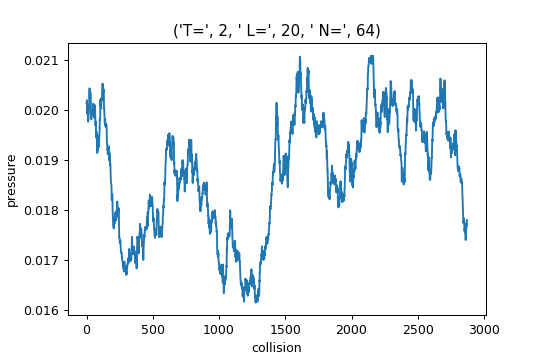

0.018946925326173824
0.33357376487210544 pred 0.32573500793528
pressure 2.7144583994606664 7.524159493798155
[ 1  8 18 17 14  5  1  0  0  0] 1 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


<IPython.core.display.Javascript object>


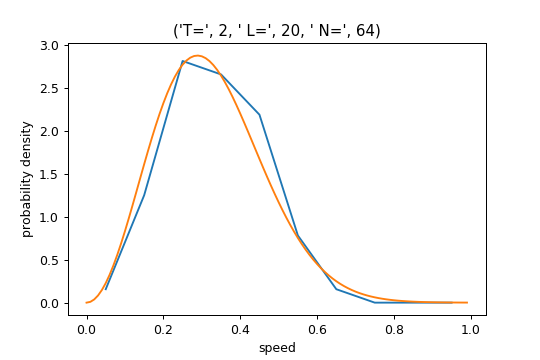

Text(0.5, 1.0, "('T=', 2, ' L=', 20, ' N=', 64)")

In [2]:

import matplotlib.pyplot as plt

'''plt.figure()
plt.plot(dmom)
'''
#plt.figure()
plt.plot(timepassed)

print('wall timer length',len(wall_timer))
print('bumpf',bumpf[-1])

avg_p = []
dmomlen = len(dmom)
print(len(dmom),len(timepassed))
for i in range(200,dmomlen-200):
    avg_p.append(sum(dmom[i-199:i+199])/((sum(wall_timer[i-199:i+199]))*6*Lbox**2))
    # the pressure is calculated by p = F/A = (delta p/delta t)/(6*Lbox^2)
    #delta p and delta t are average of 200 terms
print(len(avg_p))
plt.figure()
plt.plot(avg_p)
plt.xlabel('collision')
plt.ylabel('pressure')
pltitle = 'T=',T,' L=',L,' N=',N
plt.title(pltitle)
print(np.mean(avg_p[1000::]))


print(np.average(speed),'pred',np.sqrt(T/(6*np.pi)))
print('pressure',np.sqrt(3/(np.pi*0.6**4)),np.sqrt(bumpf[-1]**2*T*48/(16*np.pi*0.6**4)))

'''for i in range(len(dmom)):
    if dmom[i]>35:
        print(dmom[i])
'''

# distribution of speed
nbins = 10
dr = 1/nbins

speed = np.linalg.norm(vel, axis=-1) # norm of vel

histogram = np.histogram(speed, bins=nbins, range=(0, nbins*dr))

prob_dens = histogram[0]/(dr*N)
r = (histogram[1] + dr/2)[:-1] # centers of the bins
#r = (histogram[1])[:-1]

print(histogram[0],'1',histogram[1])

'''fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(r, prob_dens , color = 'b', width = 0.05)'''

plt.figure()
plt.plot(r, prob_dens)

# distribution predicted by Maxwell
vv = np.divide(range(100),100/(nbins*dr))
fv = [4*np.pi*x**2*(mass/(2*np.pi*T))**1.5*np.exp(-mass*x**2/(2*T)) for x in vv]

plt.plot(vv,fv)
plt.xlabel('speed')
plt.ylabel('probability density')
pltitle = 'T=',T,' L=',L,' N=',N
plt.title(pltitle)

<IPython.core.display.Javascript object>


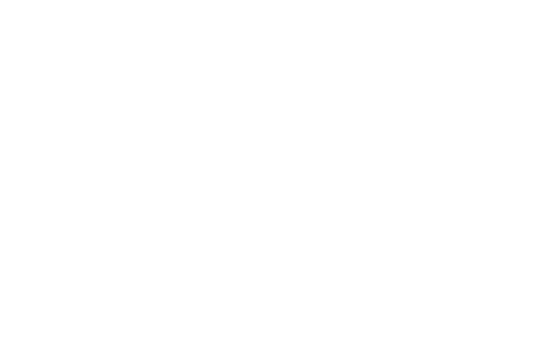

<IPython.core.display.Javascript object>


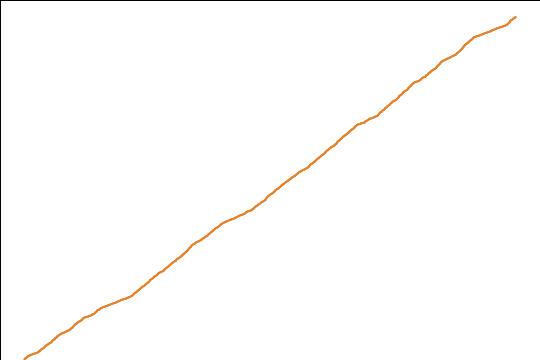

<BarContainer object of 10 artists>

In [104]:
plt.figure()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(r, prob_dens , color = 'b', width = 0.05)